In [1]:
import os, sys
sys.path.append(os.path.abspath(".."))
from time import time as timer
import numpy as np
from matplotlib import pyplot as plt

from npearth.earth import EARTH
from npearth._knotsearcher_cholesky import KnotSearcherCholesky
from npearth._knotsearcher_cholesky_numba import KnotSearcherCholeskyNumba
from npearth._knotsearcher_svd import KnotSearcherSVD

Pruning model
Cholesky took time 1.80821
Pruning model
SVD took time 1.68931
Pruning model
Numba took time 0.08797


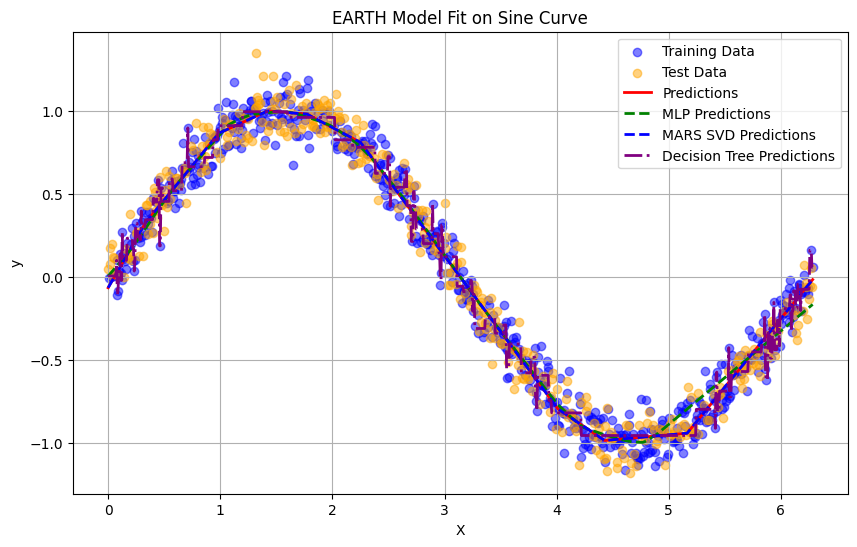

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# Step 1: Generate Sine Curve Data
def generate_sine_data(n_samples=200, noise_level=0.1, random_state=42):
    np.random.seed(random_state)
    X = np.linspace(0, 2 * np.pi, n_samples)
    y = np.sin(X) + noise_level * np.random.randn(n_samples)  # Sine curve with noise
    return X.reshape(-1, 1), y  # Reshape for sklearn compatibility

# Step 2: Split Data
n = 1000
X, y = generate_sine_data(n_samples=n, noise_level=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# Step 3: Fit the EARTH Model
earth_model = EARTH(M_max=15)
t0 = timer()
earth_model.fit(X_train, y_train)
t1 = timer()
print(f"Cholesky took time {round(t1-t0,5)}")

earth_model_svd = EARTH(M_max = 15, knot_searcher=KnotSearcherSVD)
t2 = timer()
earth_model_svd.fit(X_train, y_train)
t3 = timer()
print(f"SVD took time {round(t3-t2,5)}")

earth_model = EARTH(M_max = 15, knot_searcher=KnotSearcherCholeskyNumba)
t2 = timer()
earth_model.fit(X_train, y_train)
t3 = timer()
print(f"Numba took time {round(t3-t2,5)}")

mlp = MLPRegressor(hidden_layer_sizes=(30,30,30), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X)
y_pred_test_mlp = mlp.predict(X_test)

dt = DecisionTreeRegressor(max_depth=7)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X)
y_pred_test_dt = dt.predict(X_test)

# Step 4: Make Predictions
y_pred = earth_model.predict(X)
y_pred_test = earth_model.predict(X_test)
y_pred_svd = earth_model_svd.predict(X)
y_pred_svd_test = earth_model_svd.predict(X_test)

# Step 5: Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5)
plt.scatter(X_test, y_test, color='orange', label='Test Data', alpha=0.5)
plt.plot(X, y_pred, color='red', label='Predictions', linewidth=2)
plt.plot(X, y_pred_mlp, color='green', label='MLP Predictions', linewidth=2, linestyle='--')
plt.plot(X, y_pred_svd, color='blue', label='MARS SVD Predictions', linewidth=2, linestyle='--')
plt.plot(X, y_pred_dt, color='purple', label='Decision Tree Predictions', linewidth=2, linestyle='-.')
plt.title('EARTH Model Fit on Sine Curve')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

In [7]:
import pickle
with open('/Users/bjarkehogdall/Code/EARTH/src/npearth/data/test_model.pickle', 'wb') as handle:
    pickle.dump(earth_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/Users/bjarkehogdall/Code/EARTH/src/npearth/data/test_X.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/Users/bjarkehogdall/Code/EARTH/src/npearth/data/test_y.pickle', 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
print("sum of abs residuals MARS", np.sqrt(sum((y_test - y_pred_test)**2)).round(4))
print("sum of abs residuals DT", np.sqrt(sum((y_test - y_pred_test_dt)**2)).round(4))
print("sum of abs residuals MLP", np.sqrt(sum((y_test - y_pred_test_mlp)**2)).round(4))

sum of abs residuals MARS 2.0253
sum of abs residuals DT 2.3026
sum of abs residuals MLP 2.0504


In [9]:
print("Average absolute difference SVD and Numba: ", np.abs(y_pred_svd_test - y_pred_test).mean())

Average absolute difference SVD and Numba:  0.0


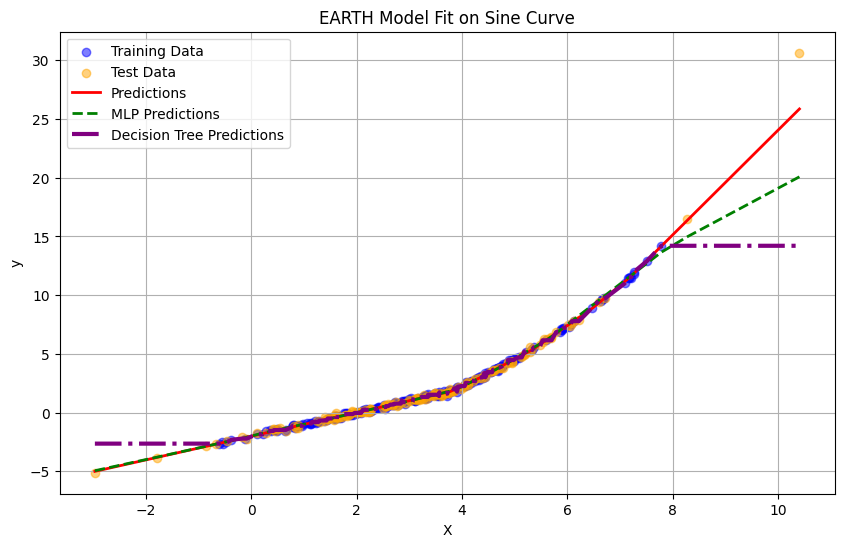

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

# Step 1: Generate Sine Curve Data
def generate_growing_data(n_samples=100, noise_level=0.1, random_state=42):
    np.random.seed(random_state)
    X = np.random.normal(np.pi, 0.6*np.pi, n_samples)
    X = np.sort(X)
    exp_cut_off = 1.2 * np.pi
    y = -2 + 1*X + np.pow(1.2, X - exp_cut_off)*np.maximum(X-exp_cut_off,0) + noise_level * np.random.randn(n_samples)  # Sine curve with noise
    return X.reshape(-1, 1), y  # Reshape for sklearn compatibility

# Step 2: Split Data
n = 400
X, y = generate_growing_data(n_samples=n, noise_level=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=30)


# Step 3: Fit the EARTH Model
earth_model = EARTH(M_max=12)
earth_model.fit(X_train, y_train)

earth_model_svd = EARTH(M_max = 12)
earth_model_svd.fit(X_train, y_train, KnotSearcherSVD)

mlp = MLPRegressor(hidden_layer_sizes=(30,30,30), max_iter=2000, random_state=42, n_iter_no_change=50)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X)
y_pred_test_mlp = mlp.predict(X_test)

dt = DecisionTreeRegressor(max_depth=7)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X)
y_pred_test_dt = dt.predict(X_test)

# Step 4: Make Predictions
y_pred = earth_model.predict(X)
y_pred_test = earth_model.predict(X_test)
y_pred_svd = earth_model_svd.predict(X)

# Step 5: Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', alpha=0.5)
plt.scatter(X_test, y_test, color='orange', label='Test Data', alpha=0.5)
plt.plot(X, y_pred, color='red', label='Predictions', linewidth=2)
plt.plot(X, y_pred_mlp, color='green', label='MLP Predictions', linewidth=2, linestyle='--')
# plt.plot(X, y_pred_svd, color='blue', label='MARS SVD Predictions', linewidth=2, linestyle='--')
plt.plot(X, y_pred_dt, color='purple', label='Decision Tree Predictions', linewidth=3, linestyle='-.')
plt.title('EARTH Model Fit on Sine Curve')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

In [24]:
print("sum of abs residuals from MARS", np.sqrt(sum((y_test - y_pred_test)**2)).round(4))
print("sum of abs residuals from DT", np.sqrt(sum((y_test - y_pred_test_dt)**2)).round(4))
print("sum of abs residuals from MLP", np.sqrt(sum((y_test - y_pred_test_mlp)**2)).round(4))

sum of abs residuals from MARS 4.9759
sum of abs residuals from DT 16.9052
sum of abs residuals from MLP 10.7763


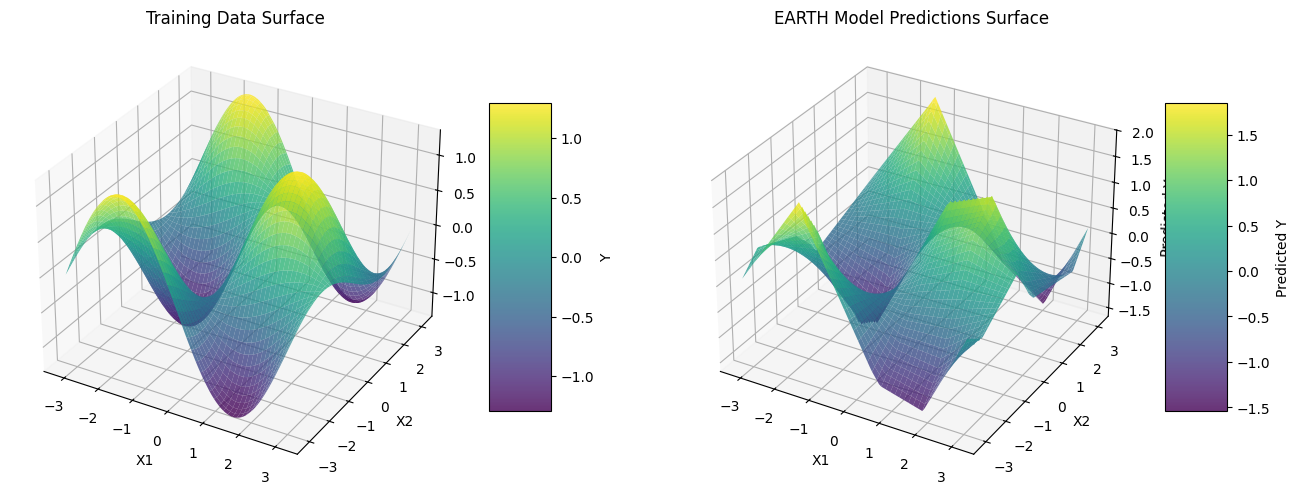

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata

# Assume EARTH class is defined and imported from your module

# Step 1: Generate Intermediate Sine Data with Noise
def generate_intermediate_sine_data_with_noise(n_samples=40, noise_level=0.1, random_state=42):
    np.random.seed(random_state)
    X1 = np.linspace(-np.pi, np.pi, n_samples)
    X2 = np.linspace(-np.pi, np.pi, n_samples)
    X1, X2 = np.meshgrid(X1, X2)  # Create meshgrid
    Y = np.sin(X1) * np.cos(X2) + 0.3 * np.sin(X1 + X2)  # Target variable

    noise = noise_level * np.random.randn(*Y.shape)  # Add noise
    Y_noisy = Y + noise

    # Flatten the arrays for training
    df = pd.DataFrame({'X1': X1.ravel(), 'X2': X2.ravel(), 'Y': Y_noisy.ravel()})
    return df

# Generate the data
data = generate_intermediate_sine_data_with_noise(n_samples=80, noise_level=0.0)    # Generate 50^2 = 2500 samples
X = data[['X1', 'X2']].values
y = data['Y'].values

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 3: Fit the EARTH Model
earth_model = EARTH(M_max=30)
earth_model.fit(X_train, y_train)

# Step 4: Create a grid for prediction
X1_grid, X2_grid = np.meshgrid(np.linspace(-np.pi, np.pi, 100), np.linspace(-np.pi, np.pi, 100))
X_grid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])  # Combine into a 2D array

# Make Predictions
y_pred = earth_model.predict(X_grid).reshape(X1_grid.shape)  # Reshape to match grid shape

# Step 5: Create side-by-side surface plots for training data and predictions
fig = plt.figure(figsize=(16, 8))

# Training Data Surface Plot
ax1 = fig.add_subplot(121, projection='3d')
# Interpolate training data for a smooth surface
grid_y_train = griddata((X_train[:, 0], X_train[:, 1]), y_train, (X1_grid, X2_grid), method='linear')
surf_train = ax1.plot_surface(X1_grid, X2_grid, grid_y_train, cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_zlabel('Y')
ax1.set_title('Training Data Surface')
fig.colorbar(surf_train, ax=ax1, shrink=0.5, aspect=5, label='Y')

# Predictions Surface Plot
ax2 = fig.add_subplot(122, projection='3d')
surf_pred = ax2.plot_surface(X1_grid, X2_grid, y_pred, cmap='viridis', edgecolor='none', alpha=0.8)
ax2.set_xlabel('X1')
ax2.set_ylabel('X2')
ax2.set_zlabel('Predicted Y')
ax2.set_title('EARTH Model Predictions Surface')
fig.colorbar(surf_pred, ax=ax2, shrink=0.5, aspect=5, label='Predicted Y')

plt.show()


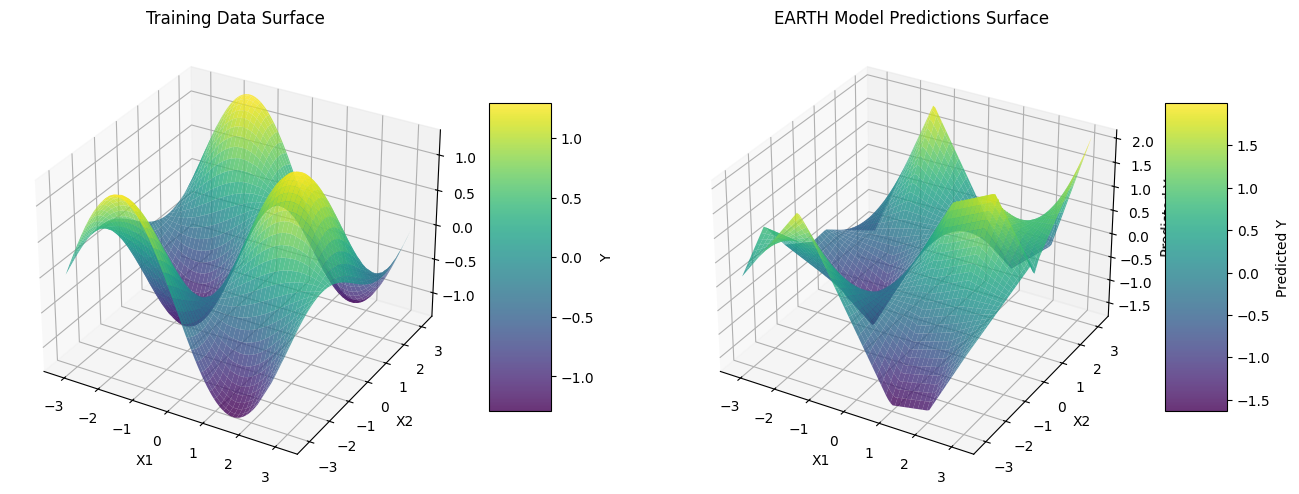